# Stock Price Forecaster
## Machine Learning Engineer Nanodegree
**Calvin Ku**

**June 6, 2016**

## Definition

### Project Overview
    This project is about building a stock price forecaster. The forecaster is built as a regressor, which tries to predict the price for a given stock for a given future date (for example, the price of GOOGL 10 days from now). The goal of this project is to build the forecaster that can predict the stock price 21 days from the day the prediction is made. We will use GOOGL as an example in this project but the same method can be applied to any stock. In the end we will evaluate our method on GOOGL and 198 randomly picked stocks (to ensure 5% margin of errors at 95% confidence level) out of 410 stocks from S&P 500 (2009). The forecaster is meant be combined with a portfolio optimizer to form a total decisioning solution for trading to give trading suggustions to investors.

#### Data used in this project
The datasets that will be used in this project include:
* Historical stock prices data collected from Yahoo Finance
* St. Louis Fed Financial Stress Index data

For the historical data, we will ready the stocks of S&P 500 (2009) range from January 1, 2009, to June 28, 2016. Some of the stocks are excluded due to not being traded as of this writing, data corruption, not propoerly adjusted, or not reliable.

### Problem Statement
Problem with trading is that you never know when is the best time to buy or sell a stock, as you never know if the stock price will go up or go down in the future. This simple forecaster is an attempt to solve this problem.

For any stock in S&P 500 (2009), the forecaster is able to predict the prices of that stock 21 days in the future. The precision of the forecast varies from stock to stock, but for the forecaster to be in anyway useful, generally we want to limit the error to be around 10% of the stock price.

### Metrics
In this project we use MSE (mean sqauared error) as the metric, since our goal is to try to make the predicted price as close to the real price as possible. To be more specific, the reason why MSE is good is because:

1. The overestimations (when the predicted value is higher than the actual) and underestimations (when lower than the actual) of the model don't cancel out when you take the average, therefore you won't underestimate the error.

2. The square of a very small value is even smaller and the square of a big value is even bigger. We are looking for a model that can consistently make predictions that stay close to the actual, and with MSE, we can punish really off predictions even more (for example, being off by 20 is a lot more than twice as bad as being off by 10) to get a consistent model.

3. One problem with MSE is that it is more susceptible to outliers. Fortunately, the good thing about financial data is that the data is quite pristine so we can expect not so much corrupted and misinput data. On the other hand, unlike cross-sectional data, the continuous nature of stock price data itself eliminates the possibility of any "special case" and makes spotting corrupted data rather easy.

Along with MSE we also log the $R^2$. $R^2$ is the normalized MSE. And since it's normalized, we can use it to compare the model performance across multiple stocks.

## Analysis
### Data Exploration
About the data used in this project, we assume the following:

* CAPM (Capital Asset Pricing Model), where it states that any stock price on the market is a multitude (or a fraction) of the market trend $\beta$ (in our case, we use the stock price of SPY), plus a constant $\alpha$ which is specific to that stock. 
* Believing that economy is correlated to the the stock market
* Believing that any price change without a good amount of volume behind is just a random fluctuation

Therefore, the raw data used in this project includes the following:

* SPY Adj Close
* SPY Volume
* Adj Close of the target stock
* Volume of the target stock
* STLFSI - St. Louis Fed Financial Stress Index data

Since SPY is always traded in the trading days, we use it to get the trading days.

#### First look
Let's first take a glance at our data and see if there's any missing values. Again, in the demonstration, we use GOOGL as our example. The method can be applied to any other stocks.

In [1]:
from __future__ import division

# Data Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random
from IPython.display import display

# Set global random seeds
np.random.seed(0)
random.seed(0)

def load_data(stock_list_csv, market_csv, start_date, end_date, symbol_list=None, random_state=0, number_of_stocks=1, include_stocks=None):
    """The function does the following:
    1. Load the list of stocks
    2. Load the market data (SPY or other ETF data)
    3. Load the economy data (STLFSI or other index data)
    4. Randomly picks 10 stocks and load into a dictionary of dataframes if symbol_list is not provided,
       otherwise load the stocks in the symbo_list instead
    5. Return a dictionary of dataframes of stock data, with stock symbols as the keys
    """
    start_time = time.time()
    
    # Set up the empty main dataframe using the defined data range
    date_range = pd.date_range(start_date, end_date)
    df_main = pd.DataFrame(index=date_range)
    
    # Load SPY to get trading days
    dfSPY = pd.read_csv(market_csv, index_col='Date', parse_dates=True, usecols=['Date', 'Adj Close', 'Volume'], na_values = ['nan'])
    dfSPY = dfSPY.rename(columns={'Adj Close': 'SPY', 'Volume': 'SPY_Vol'})
    
    # Get SPY within the target date range
    df_main = df_main.join(dfSPY)
    
    # Drop NaN values
    df_main = df_main.dropna()
    
    # Load target stock list
    dfSPY500_2009 = pd.read_csv(stock_list_csv, header=None, usecols = [1])
    
    # Ready the symbol list
    if symbol_list is None:
#         np.random.seed(random_state)
        symbol_list = np.random.choice(dfSPY500_2009[1].tolist(), size=number_of_stocks, replace=False).tolist()
    
    if include_stocks is not None:
        try:
            symbol_list.extend(include_stocks)
            symbol_set = set(symbol_list)
            symbol_list = list(symbol_set)
        except TypeError:
            print("The stocks to be included should be put in a list.")

    
    # Load the FSI data
    dfFSI = pd.read_csv('STLFSI.csv', index_col='DATE', parse_dates=True, na_values = ['nan'])
    
    # Load target stocks
    result_dict = {}
    
    for symbol in symbol_list:
        if symbol != 'SPY':
            df_temp = pd.read_csv('stock_data/' + symbol + '.csv', index_col="Date", parse_dates=True, usecols = ['Date', 'Volume', 'Adj Close'], na_values=['nan'])
            df_temp = df_temp.rename(columns={'Volume': symbol + '_Vol', 'Adj Close': symbol})
            df_temp2 = df_main.join(df_temp, how='left')
            df_temp2 = df_temp2.join(dfFSI, how='left')
            result_dict[symbol] = {'original_data': df_temp2}
    
    print("{} seconds elapsed for loading data.".format(time.time() - start_time))
    print("\n")
    return result_dict

# Set stock
symbol = 'GOOGL'

# Set date range
start_date = '2009-01-01'
end_date = '2016-06-30'

# Load stock dataframes into dictionary
stock_dict = load_data('sp500_2009.csv', 'stock_data/SPY.csv', start_date, end_date, number_of_stocks=199, include_stocks=[symbol])

# Get target stock names
print("Stocks included:")
print(stock_dict.keys())

# Set example stock dataframe
df_main = stock_dict[symbol]['original_data']

# First glance at the data
display(df_main.head())

# Inspect missing values
print("Inspect missing values:")
print(df_main.isnull().sum())


1.47196602821 seconds elapsed for loading data.


Stocks included:
['AGN', 'NSC', 'EOG', 'GOOGL', 'WM', 'BK', 'HAR', 'EXC', 'ADM', 'TAP', 'VNO', 'AON', 'FLIR', 'PRU', 'SPLS', 'HST', 'DDR', 'HRB', 'SPG', 'CTSH', 'OMC', 'GT', 'HAL', 'GR', 'FITB', 'EQR', 'L', 'GD', 'T', 'MRK', 'XLNX', 'FII', 'PH', 'GPS', 'VRSN', 'PHM', 'SYK', 'NTRS', 'RHI', 'CINF', 'APH', 'JNJ', 'LXK', 'APD', 'TSN', 'AA', 'AES', 'MWW', 'KSS', 'WFM', 'FLR', 'PAYX', 'CMA', 'AMAT', 'FTR', 'AEE', 'NVDA', 'EMR', 'WYNN', 'CMS', 'JPM', 'TMK', 'VLO', 'MET', 'HUM', 'PX', 'COL', 'PG', 'LLL', 'CTXS', 'PKI', 'AMT', 'AFL', 'HCP', 'IGT', 'ED', 'BLL', 'QCOM', 'CSX', 'YHOO', 'BDX', 'BTU', 'MA', 'CBG', 'PSA', 'NOC', 'MU', 'ODP', 'SE', 'MCHP', 'TJX', 'ALTR', 'AVB', 'ETR', 'DVN', 'LUV', 'SNDK', 'PEP', 'IBM', 'COST', 'ACAS', 'COH', 'LUK', 'DOW', 'GLW', 'SCHW', 'BSX', 'FCX', 'RRC', 'NE', 'FAST', 'UPS', 'BBBY', 'MDT', 'EXPD', 'UNP', 'BHI', 'CI', 'DUK', 'ADP', 'DNB', 'GILD', 'ADBE', 'CF', 'R', 'ESRX', 'UNH', 'MCK', 'BBT', 'ADI', 'CHRW', 'ALL', 

,SPY_Vol,SPY,GOOGL_Vol,GOOGL,STLFSI
2009-01-02,227566300.0,79.602650,7213700,160.820818,3.643
2009-01-05,240349700.0,79.508455,9768200,164.189196,NaN
2009-01-06,328260900.0,80.039370,12837500,167.197207,NaN
2009-01-07,280899200.0,77.641697,8980000,161.166170,NaN
2009-01-08,263834400.0,77.958535,7194100,162.757754,NaN


Inspect missing values:
SPY_Vol         0
SPY             0
GOOGL_Vol       0
GOOGL           0
STLFSI       1510
dtype: int64


We can see that we don't have any missing values to be taken care of for GOOGL. The financial stress index is calculated weekly so we'll have to fill in for the dates between the calculations ourselves.

#### A closer look
Now let's take a look at the statistics of the stock price data.

In [2]:
# Inspect the stock price column
n_days = df_main.shape[0]
min_price = df_main[symbol].min()
max_price = df_main[symbol].max()
mean_price = df_main[symbol].mean()
median_price = np.median(df_main[symbol])
std_price = df_main[symbol].std()
cv = std_price / mean_price

print("Number of traded days: {}".format(n_days))
print("Minimum stock price: {}".format(min_price))
print("Maximum stock price: {}".format(max_price))
print("Mean stock price: {}".format(mean_price))
print("Median stock price: {}".format(median_price))
print("Standard deviation of stock price: {}".format(std_price))
print("Coefficient of variation of stock price: {}".format(cv))

Number of traded days: 1885
Minimum stock price: 141.516512
Maximum stock price: 793.960022
Mean stock price: 412.004713227
Median stock price: 340.700719
Standard deviation of stock price: 170.050499998
Coefficient of variation of stock price: 0.41273921035


We can see that we don't have any outliers here in the stock price data. And the coefficient of variation is less than 1.

Let's inspect the statistics of other features.

In [3]:
# Inspect all columns
display(df_main.describe())

,SPY_Vol,SPY,GOOGL_Vol,GOOGL,STLFSI
count,1.885000e+03,1885.000000,1.885000e+03,1885.000000,375.000000
mean,1.645517e+08,142.012669,4.650994e+06,412.004713,-0.677891
std,8.730687e+07,43.102172,3.120021e+06,170.050500,0.992101
min,3.731780e+07,58.323328,5.206000e+05,141.516512,-1.655000
25%,1.040035e+08,105.351470,2.439400e+06,277.122135,-1.300500
50%,1.437597e+08,130.852555,4.097400e+06,340.700719,-0.916000
75%,2.023543e+08,187.428955,5.807300e+06,552.510010,-0.482000
max,7.178287e+08,211.271298,2.961990e+07,793.960022,3.643000


Here we can see that the distribution of our data are generally skewed and the scales for different features are wildly different.

To better see this, let's view our data in visual.

### Exploratory Visualization
First let's have a look at our target variable:

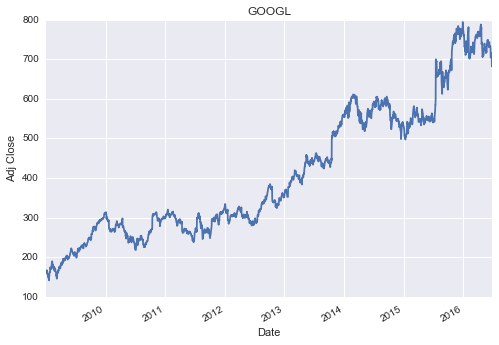

In [4]:
# Inspect stock trend
ax = df_main[symbol].plot(title=symbol)
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close")

To better see how our data are distributed and how they correlate, we can use a scatter matrix, with density plot in the diagonal.

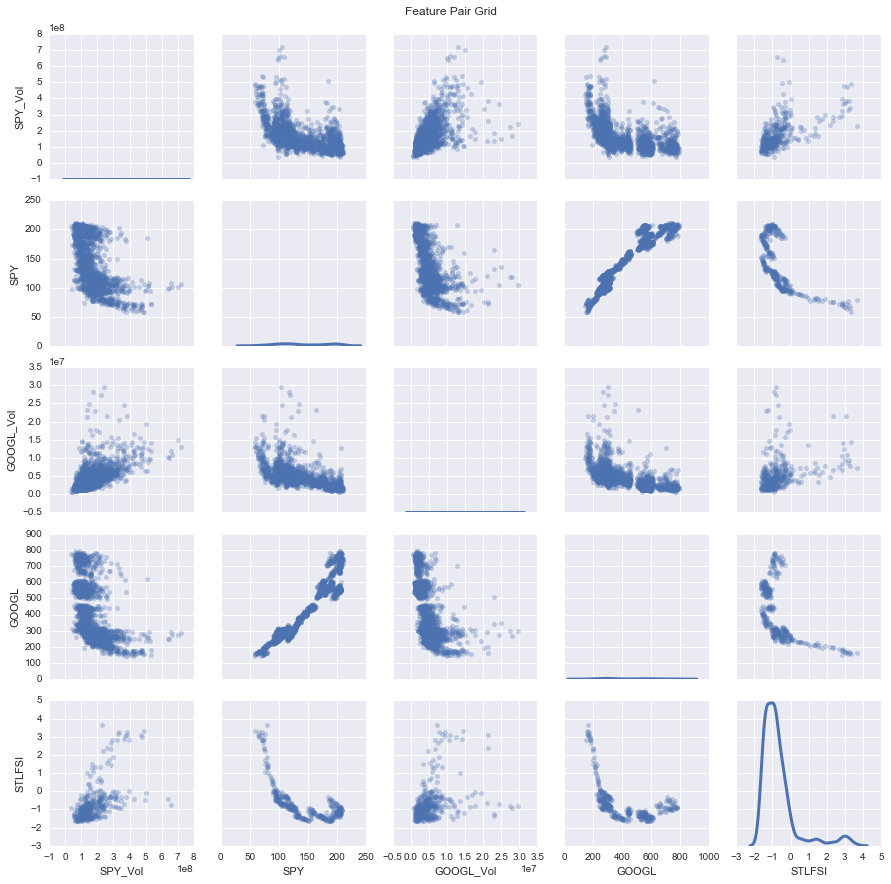

In [5]:
# Save time during Dev
g = sns.PairGrid(df_main)
g.map_upper(plt.scatter, alpha=0.3)
g.map_lower(plt.scatter, alpha=0.3)
g.map_diag(sns.kdeplot, lw=3, legend=False)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Feature Pair Grid')

We can see really clear correlations among SPY, GOOGL and STLFSI. However, most of the features in our dataset are not normally distributed, and the scales differ wildly. We can't visualize the density graphs well in this plot before we apply feature scaling. A common practice for sovling problems like this for financial data is to apply non-linear transformation to the data. Since some of our features have negative values, we can use a modified version of logorithm transform, the signed logorithm transform to our dataset.

### Algorithms and Techniques
#### Algorithms
In this project we will use the random forest algorithm to model our data. The random and ensemble nature of the algorithm makes it very unlikely to overfit on the training data. Furthermore, random forest is very easy to tune. We can easily grid search through the number of choice of features for each splitting and the number of trees. In addition to this, the ensemble nature of the algorithm makes it scalable when we need to: 1. train on more data, 2. build more trees, 3. include more stocks to forecast. Overall, random forest generally gives good results and it has been recognized that ensemble algorithms like random forest perform over other traditional regression algorithms in the Kaggle community over the years.

#### Other techniques
##### Training data with "rolling training"
The part where stock market forecasting really differs from a lot of problems is that we are dealing with a highly time-dependent system. This means the data we collect for training is only valid within a range of time. In this project we will choose 100 days as our window size. For each data point we try to predict it's stock price by the model built only with the data from the past 121 days to the past 21 days, and move that window forward to predict for the next date. 

### Benchmark
Generally we want our model to be able to predict stock prices with less than 10% error of the stock price. Our prediction is based on real data so the errors do not accumulate one on top of another. Although this benchmark might not be useful for really short period trading or with stocks that don't go up and down very much, it is good enough to be used in mid to long-term tradings.

## Methodology
### Data Preprocessing
#### Treating missing values
As discussed earlier, we have 1510 records missing for STLFSI due to how it is weekly calculated. We need to forward fill (to prevent the problem of peeking-into-the-future) and then back fill for days where the data is unavailable.

In [6]:
### Forward/Back Fill missing data
def fill_missing_data(stock_dict):
    for stock_name in stock_dict:
        stock_dict[stock_name]['original_data'].fillna(method='ffill', inplace=True)
        stock_dict[stock_name]['original_data'].fillna(method='bfill', inplace=True)

    return stock_dict

stock_dict = fill_missing_data(stock_dict)
df_main = stock_dict[symbol]['original_data']

## Display
# df_main[symbol].plot()
display(df_main.head(10))
print(df_main.isnull().sum())

,SPY_Vol,SPY,GOOGL_Vol,GOOGL,STLFSI
2009-01-02,227566300.0,79.602650,7213700,160.820818,3.643
2009-01-05,240349700.0,79.508455,9768200,164.189196,3.643
2009-01-06,328260900.0,80.039370,12837500,167.197207,3.643
2009-01-07,280899200.0,77.641697,8980000,161.166170,3.643
2009-01-08,263834400.0,77.958535,7194100,162.757754,3.643
2009-01-09,330953600.0,76.288725,8672300,157.692690,3.171
2009-01-12,277858500.0,74.456220,6601900,156.501497,3.171
2009-01-13,356432300.0,74.593233,8856100,157.317324,3.171
2009-01-14,435491600.0,72.246943,10924800,150.635637,3.171
2009-01-15,532647300.0,72.272632,11857100,149.644640,3.171


SPY_Vol      0
SPY          0
GOOGL_Vol    0
GOOGL        0
STLFSI       0
dtype: int64


#### Priliminary feature scaling and creating labels
As discussed earlier, we can do a simple signed-log tranform to our data to bring all features to the same scale. The non-linear nature of the transform also helps normalize the data which is crucial for many machine learning algorithms.

##### Create and separate out labels
Since we don't need to apply feature scaling to the labels (target variable), we will separate it out first. Our goal is to predict prices 21 days from the day of prediction. We can use pandas shift method to achieve this.

In [7]:
## Split and create label data
def split_data(stock_dict):
    for stock_name in stock_dict:
        stock_dict[stock_name]['data_y'] = stock_dict[stock_name]['original_data'][stock_name]

    return stock_dict

## Apply n-day shift to data
def create_n_day_forecast_data(df, symbol, day):
    df = df.shift(-day)
    return df

## Add label_name key to dictionary for the feature engineering stage
def add_label_name_to_stock_dict(stock_dict, window):
    for stock_name in stock_dict:
        stock_dict[stock_name]['label_name'] = stock_name + str(window) + 'd'
    return stock_dict

## Assign the generated labels to 'data_y'
def create_label_data(stock_dict, window):
    for stock_name in stock_dict:
        stock_dict[stock_name]['data_y'] = create_n_day_forecast_data(stock_dict[stock_name]['data_y'], stock_name, window)
    return stock_dict

def ready_label_data(stock_dict, window):
    stock_dict = split_data(stock_dict)
    stock_dict = add_label_name_to_stock_dict(stock_dict, window)
    stock_dict = create_label_data(stock_dict, window)
    
    return stock_dict

# Ready label data
window = 21
stock_dict = ready_label_data(stock_dict, window)

for stock_name in stock_dict:
    stock_dict[stock_name]['data_y'].dropna(inplace=True)

label_name = stock_dict[symbol]['label_name']
data_y = stock_dict[symbol]['data_y']

##### Preliminary feature scaling
The reader may have noticed we are keeping the price data. This is because we will need it for the feature engineering stage, thus we are keeping it and also scaling it along with other features.

0.213573932648 seconds elapsed for log transforming data.


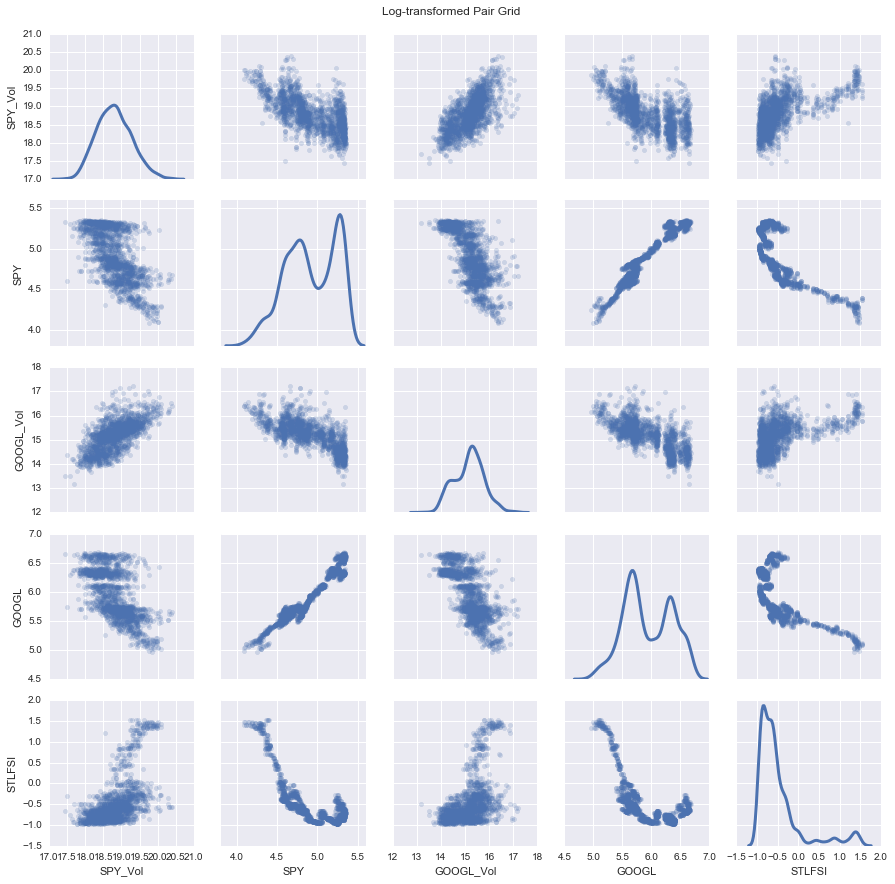

In [8]:
# Signed-log transform
log_start_time = time.time()
for stock_name in stock_dict:
    stock_dict[stock_name]['log_data'] = np.sign(stock_dict[stock_name]['original_data']) * np.log(abs(stock_dict[stock_name]['original_data']) + 1)

log_data = stock_dict[symbol]['log_data']
print("{} seconds elapsed for log transforming data.".format(time.time() - log_start_time))

# Save time during Dev
g = sns.PairGrid(log_data)
g.map_upper(plt.scatter, alpha=0.2)
g.map_lower(plt.scatter, alpha=0.2)
g.map_diag(sns.kdeplot, lw=3, legend=False)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Log-transformed Pair Grid')

Now the trends have become more clear. Not only can we see very clean-cut relationships between GOOGL and SPY but also good correlations between stock prices and stock volumes, and prices and the STLFSI.

This lays a good foundation for us to do further feature engineering for our data.

#### Feature engineering
In this section we add a few features and remove some raw ones. The following are the complete feature list:

* **STLFSI: **St. Louis Fed Financial Stress Index data (foward filled) 
* **Beta (63 days): **$\beta = \frac{Cov(r_a, r_b)}{Var(r_b)}$
* **EMA (100 days): **$EMA_{today} = EMA_{yesterday} + \alpha \times (price_{today} - EMA_{yesterday}) \ \text{where }\alpha = \frac{2}{N+1}$
* **MMA: ** $MMA_{today} = \frac{(N-1) \times MMA_{yesterday} + price}{N}$
* **SMA (100 days): ** $SMA_{today} = \frac{\Sigma\ prices}{\text{number of days}}$
* **Price Momentum (100 days): ** $\frac{Momentum}{N + 1} = SMA_{today} - SMA_{yesterday}$
* **SP500 SMA Change (100 days): ** $SMA_{today} - SMA_{yesterday} = \frac{P_M - P_{M-n}}{n}$
* **SP500 Volatility (63 days): ** $Std(r_{SP})$
* **Sharpe Ratio (63 days): ** $\text{Sharpe Ratio} = \frac {r_a - r_{SP}}{\sigma_{r_a}}$
* **Volatility (63 days): ** $\sigma_{r_a}$
* **Volume Momentum (100 days): ** $\frac{\text{Volume Momentum}}{N + 1} = Volume_{today} - Volume_{yesterday}$
* **Volume Marker 1: ** 
$
              \left\{
                \begin{array}{ll}
                  1, \ \text{if Volume Momentum} \geqslant 0\\
                  0, \ \text{otherwise}
                \end{array}
              \right.
$
* **Volume Marker 2: **
$
              \left\{
                \begin{array}{ll}
                  1, \ \text{if Volume is greater than the mean + standard deviation}\\
                  0, \ \text{otherwise}
                \end{array}
              \right.
$
* **Volume Marker 3: **
$
              \left\{
                \begin{array}{ll}
                  1, \ \text{if Volume is greater than the mean - standard deviation}\\
                  0, \ \text{otherwise}
                \end{array}
              \right.
$

5021.66169095 seconds elapsed for feature engineering.


,STLFSI,GOOGL_Std63d,GOOGL_Beta,GOOGL_EMA,GOOGL_MMA,GOOGL_SMA,GOOGL_SMA_Momentum,GOOGL_Vol_Momentum,GOOGL_Vol_M1,GOOGL_Vol_M2,GOOGL_Vol_M3,GOOGL_SR63d,SPY_SMA_Momentum,SPY_Std63d,GOOGL21d
2009-05-29,0.938052,0.004201,0.982632,5.346268,5.161414,5.181363,0.259779,-0.781512,0.0,0.0,0.0,0.153166,0.002465,0.005229,5.362617
2009-06-01,0.938052,0.004127,0.952905,5.368279,5.163483,5.183949,0.261188,22.906757,1.0,0.0,1.0,0.195960,0.027261,0.005037,5.356615
2009-06-02,0.938052,0.004121,0.950854,5.372564,5.165574,5.186398,0.247427,-23.850313,0.0,0.0,0.0,0.203206,0.021522,0.005025,5.350458
2009-06-03,0.938052,0.004075,0.991606,5.380087,5.167719,5.189284,0.291465,30.052397,1.0,0.0,1.0,0.226397,0.038978,0.005017,5.325200
2009-06-04,0.938052,0.003913,0.969578,5.399792,5.170040,5.192268,0.301404,2.966613,1.0,0.0,1.0,0.284375,0.044196,0.004819,5.327925


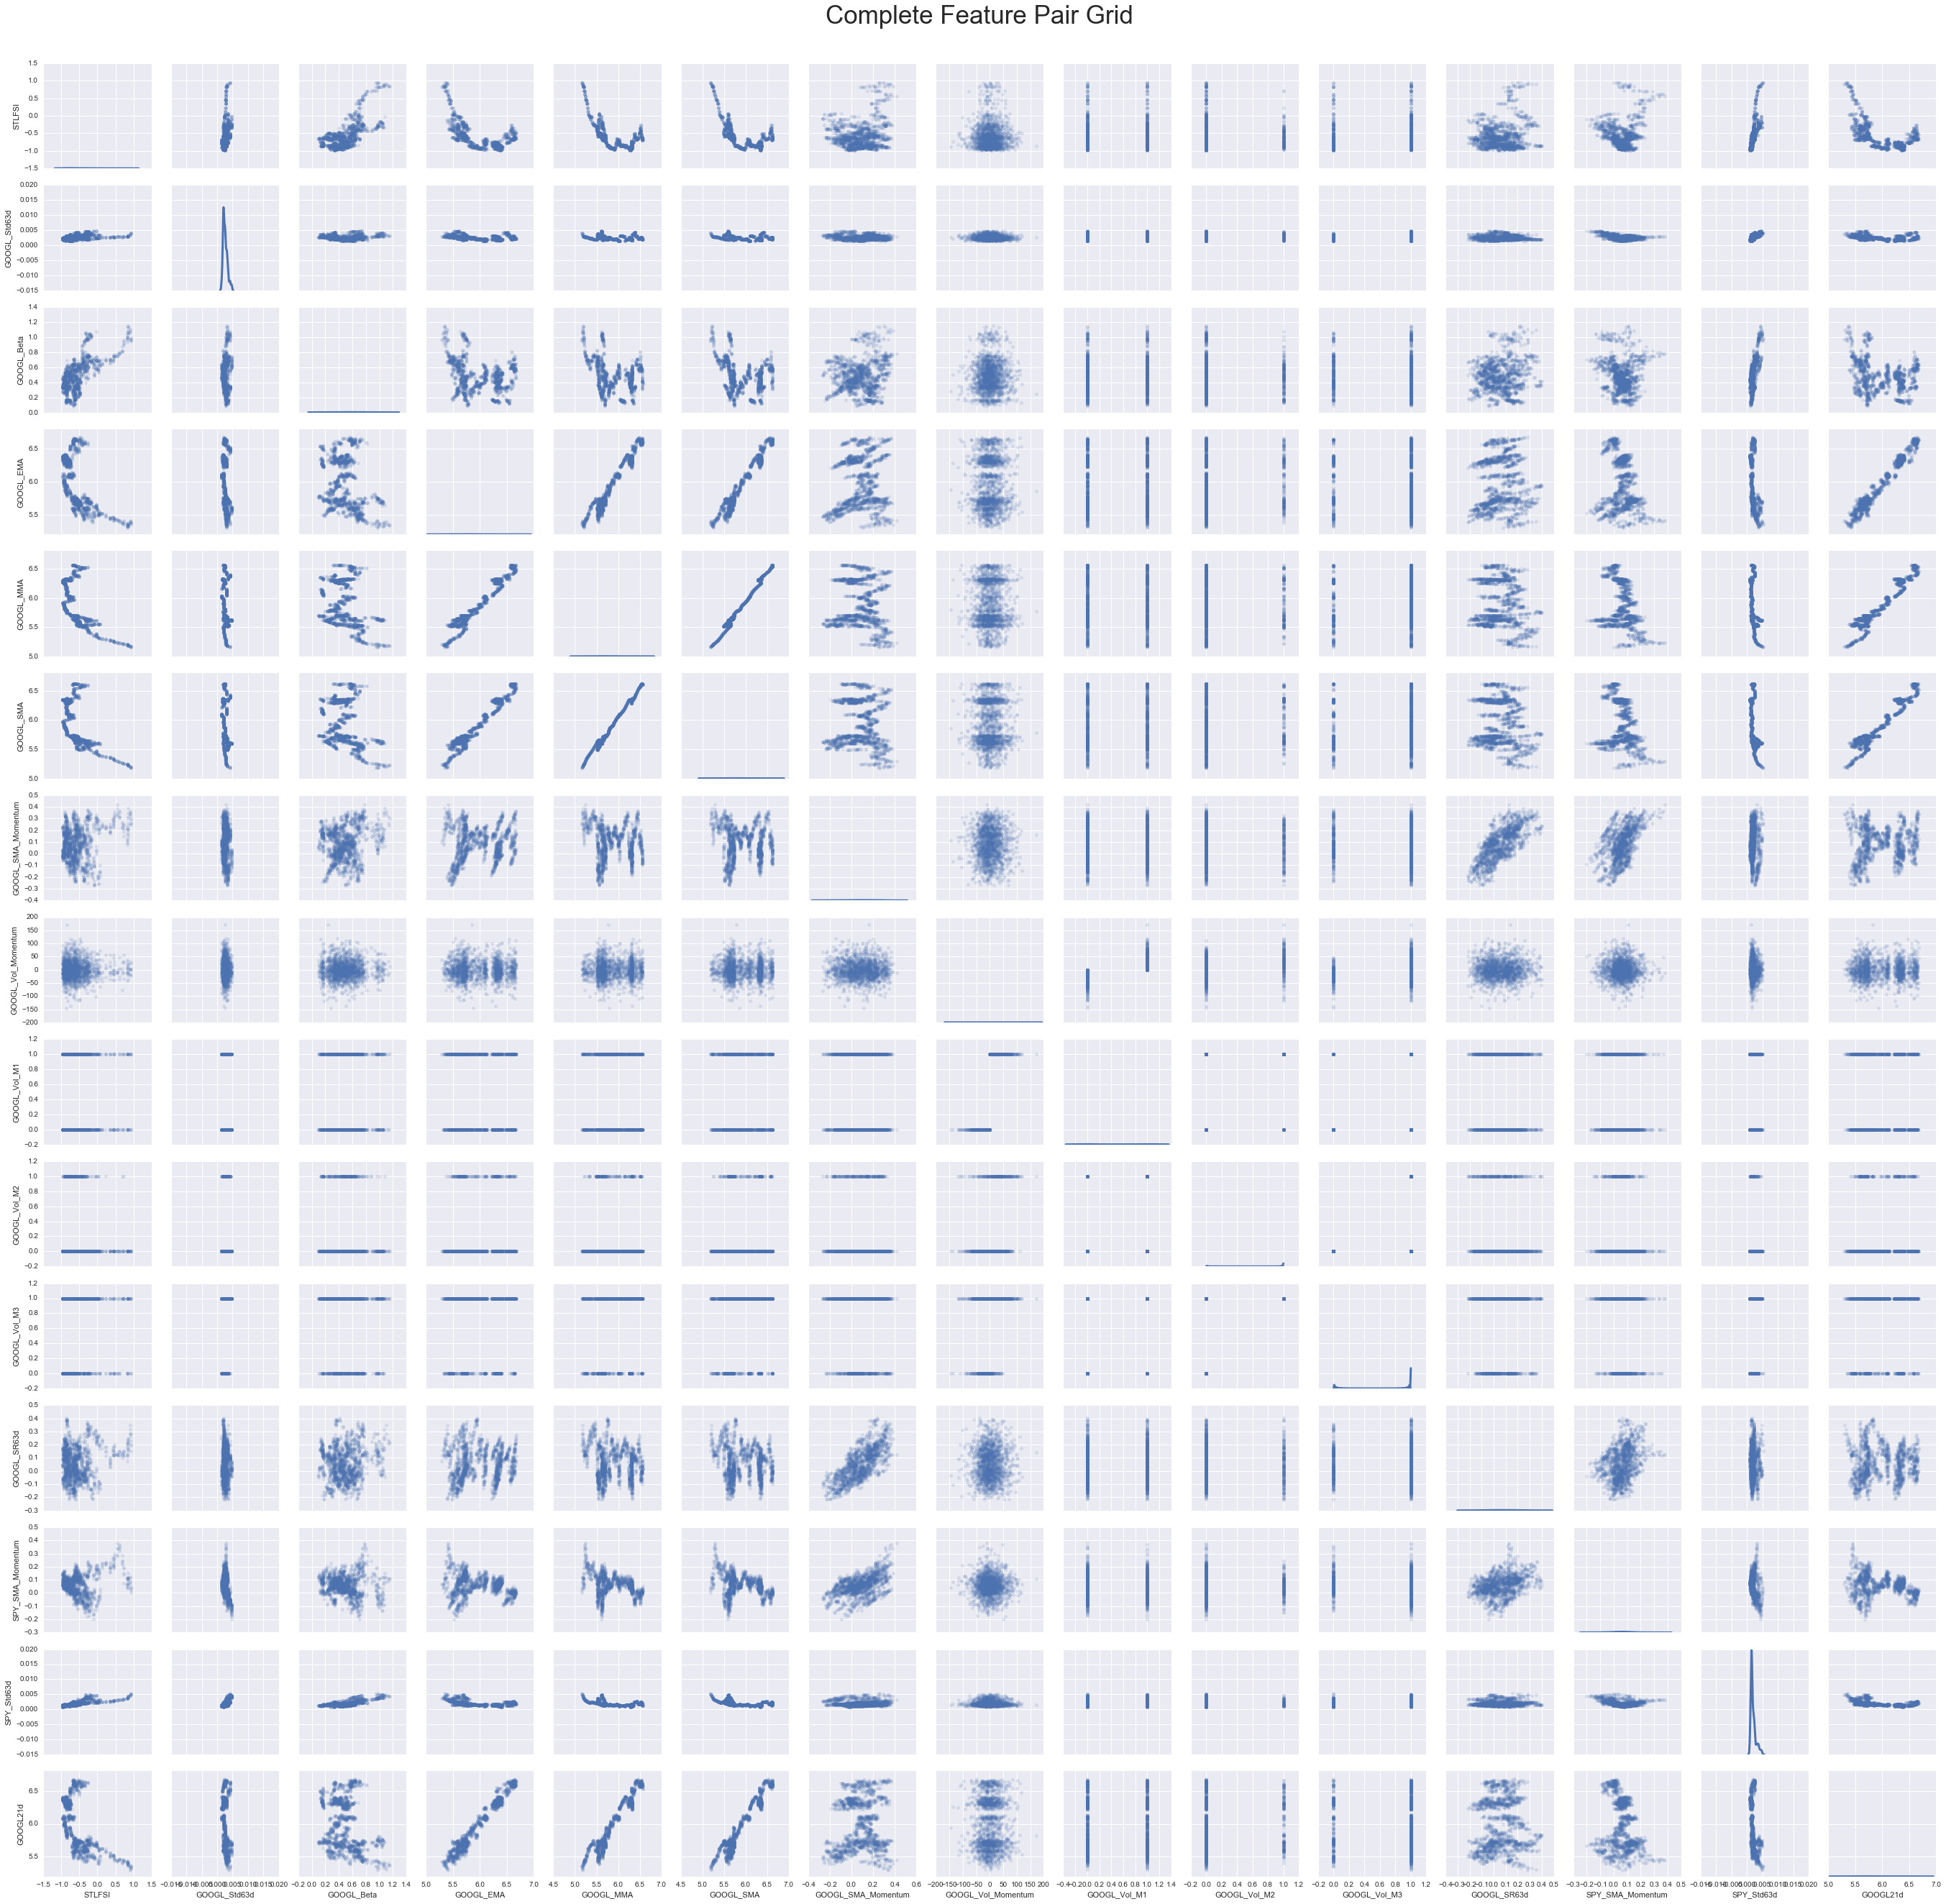

In [9]:
### Feature Engineering Section
### Make Daily Return Columns
def compute_daily_returns(df, adj_close_name):
    return (df / df.shift(1) - 1)[adj_close_name]

def make_daily_return_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)

    for symbol in symbols:
        df[symbol + '_return'] = compute_daily_returns(df, symbol)

    return df

### Make Beta columns (63 days)
def make_mean_std_columns(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    mean_dict = {}
    std_dict = {}

    for symbol in symbols:
        mean_dict[symbol] = []
        std_dict[symbol] = []

        for i in df.index:
            (u,) = df.index.get_indexer_for([i])
            if u - 63 >= 0:
                mean_dict[symbol].append(df[symbol + '_return'].iloc[u - 62:u+1].mean())
                std_dict[symbol].append(df[symbol + '_return'].iloc[u - 62:u+1].std())
            else:
                mean_dict[symbol].append(np.nan)
                std_dict[symbol].append(np.nan)

        df[symbol + '_Mean63d'] = mean_dict[symbol]
        df[symbol + '_Std63d'] = std_dict[symbol]

    return df

def make_beta_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    cov_dict = {}

    for symbol in symbols:
        cov_dict[symbol] = []
        for i in df.index:
            (u,) = df.index.get_indexer_for([i])
            if u - 62 >= 0:
                cov_dict[symbol].append(df['SPY_return'].iloc[(u - 62):u+1].cov(df[symbol + '_return'].iloc[(u - 62):u+1]))
            else:
                cov_dict[symbol].append(np.nan)
        df[symbol + '_Cov63d'] = cov_dict[symbol]
        df[symbol + '_Beta'] = df[symbol + '_Cov63d'] / df[symbol + '_Std63d']**2

    return df

### Make EMA column (100 days)
def make_ema_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)

    EMA_dict = {}
    alpha = 2 / (100 + 1)

    for symbol in symbols:
        EMA_dict[symbol] = []
        EMA_dict[symbol].append(df[symbol].iloc[0])

        for i in df.index[1:]:
            (u,) = df.index.get_indexer_for([i])
            EMA_dict[symbol].append(EMA_dict[symbol][u - 1] + alpha * (df[symbol].iloc[u] - EMA_dict[symbol][u - 1]))

        df[symbol + '_EMA'] = df[symbol]
    
    return df

### Make MMA column (100 days)
def make_mma_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    MMA_dict = {}
    alpha = 1 / 100

    for symbol in symbols:
        MMA_dict[symbol] = []
        MMA_dict[symbol].append(df[symbol].iloc[0])

        for i in df.index[1:]:
            (u,) = df.index.get_indexer_for([i])
            MMA_dict[symbol].append(MMA_dict[symbol][u - 1] + alpha * (df[symbol].iloc[u] - MMA_dict[symbol][u - 1]))

        df[symbol + '_MMA'] = MMA_dict[symbol]

    return df    

# ### Make SMA column (100 days)
def make_sma_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    for symbol in symbols:
            df[symbol + '_SMA'] = df[symbol].rolling(window=101, center=False).mean()

    return df

### SMA Momentum
def compute_SMA_momentum(df, SMA_column):
    return (df - df.shift(1))[SMA_column]*(100 + 1)

def make_sma_momentum_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    for symbol in symbols:
        df[symbol + '_SMA_Momentum'] = compute_SMA_momentum(df, symbol + '_SMA')

    return df

### Volume Momentum
def compute_Volume_momentum(df, Volume_column):
    return (df - df.shift(1))[Volume_column]*(100 + 1)

def make_vol_momentum_column(symbol, df):
    df[symbol + '_Vol_Momentum'] = compute_Volume_momentum(df, symbol + '_Vol')
    
    return df

### Vol_Momentum Marker 1
def make_vol_momentum_marker1_column(symbol, df):
    df[symbol + '_Vol_M1'] = np.nan
    df.loc[df[symbol + '_Vol_Momentum'] >= 0, symbol + '_Vol_M1'] = 1
    df.loc[df[symbol + '_Vol_Momentum'] < 0, symbol + '_Vol_M1'] = 0

    return df

### Vol_Momentum Marker 2
def make_vol_momentum_marker2_column(symbol, df):
    df[symbol + '_Vol_M2'] = np.nan
    df.loc[df[symbol + '_Vol'] >= (df[symbol + '_Vol'].rolling(window=101, center=False).mean() + df[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M2'] = 1
    df.loc[df[symbol + '_Vol'] < (df[symbol + '_Vol'].rolling(window=101, center=False).mean() + df[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M2'] = 0

    return df

### Vol_Momentum Marker 3
def make_vol_momentum_marker3_column(symbol, df):
    df[symbol + '_Vol_M3'] = np.nan
    df.loc[df[symbol + '_Vol'] < (df[symbol + '_Vol'].rolling(window=101, center=False).mean() - df[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M3'] = 0
    df.loc[df[symbol + '_Vol'] >= (df[symbol + '_Vol'].rolling(window=101, center=False).mean() - df[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M3'] = 1
    
    return df

### Make SR column
def make_SR_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    for symbol in symbols:
        df[symbol + '_SR63d'] = df[symbol + '_return'].rolling(window=63, center=False).mean() / df[symbol + '_Std63d']
    
    return df

### Drop not used SPY columns    
### Put back SPY keeper
def drop_keep_SPY_columns(symbol, df):
    ### Drop not used SPY columns    
    SPY_keeper = df[['SPY_SMA_Momentum', 'SPY_Std63d']]

    for column in df.columns:
        if 'SPY' in column:
            df.drop([column], axis=1, inplace=True)

    ### Put back SPY keeper
    df = pd.concat([df, SPY_keeper], axis=1)

    return df

### Drop not used columns
### Drop NaN rows
def drop_unused_nan_columns(symbol, df):
    ### Drop not used columns
    try:
        df.drop([symbol, symbol + '_return', symbol + '_Mean63d', symbol + '_Cov63d', symbol + '_Vol'], axis=1, inplace=True)
    except ValueError:
        print('OK, seems like these columns are already gone...')
    
    ### Drop NaN rows
    df.dropna(inplace=True)
        
    return df

def feature_engineer(symbol, df):    
    df = make_daily_return_column(symbol, df)
    df = make_mean_std_columns(symbol, df)
    df = make_beta_column(symbol, df)
    df = make_ema_column(symbol, df)
    df = make_mma_column(symbol, df)
    df = make_sma_column(symbol, df)
    df = make_sma_momentum_column(symbol, df)
    df = make_vol_momentum_column(symbol, df)
    df = make_vol_momentum_marker1_column(symbol, df)
    df = make_vol_momentum_marker2_column(symbol, df)
    df = make_vol_momentum_marker3_column(symbol, df)
    df = make_SR_column(symbol, df)
    df = drop_keep_SPY_columns(symbol, df)
    df = drop_unused_nan_columns(symbol, df)
    
    return df

feature_eng_start_time = time.time()

for stock_name in stock_dict:
    stock_dict[stock_name]['log_data'] = feature_engineer(stock_name, stock_dict[stock_name]['log_data'])
    stock_dict[stock_name]['data_X'] = stock_dict[stock_name]['log_data']
    stock_dict[stock_name]['data_y'] = stock_dict[stock_name]['data_y'].ix[stock_dict[stock_name]['data_X'].index]
    stock_dict[stock_name]['data_y'].dropna(inplace=True)
    stock_dict[stock_name]['data_X'] = stock_dict[stock_name]['data_X'].ix[stock_dict[stock_name]['data_y'].index]

print("{} seconds elapsed for feature engineering.".format(time.time() - feature_eng_start_time))

log_data = stock_dict[symbol]['log_data']
data_X = stock_dict[symbol]['data_X']
data_y = stock_dict[symbol]['data_y']

# Inspect the scatter matrix (full)
data_y_temp = data_y.copy().rename(columns=[label_name])
full_data = data_X.copy()
full_data[label_name] = np.sign(data_y_temp) * np.log(abs(data_y_temp) + 1)
display(full_data.head())

g = sns.PairGrid(full_data)
g.map_upper(plt.scatter, alpha=0.15)
g.map_lower(plt.scatter, alpha=0.15)
g.map_diag(sns.kdeplot, lw=3, legend=False)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Complete Feature Pair Grid', fontsize = 35)

From the scatter matrix we can clearly see EMA, MMA and SMA are showing good correlations with the target variables, STLFSI is also showing some trend. This tells us that we're not too far off the track.

## Implementation
In this section we will train our model and backtest it with the metrics we have defined earlier.

#### Rolling Training
As mentioned earlier, due to the nature of time series data, we will use a different method than our usual way with cross-sectional data. As said in the earlier section, we will use 100 days for our window size. For each data point we try to predict its stock price by the model built only with the data from the past 121 days (with a 21-day gap), and move that window forward to predict for the next date. Note that our label is not the stock price of the day of predition, but 21 trading days from that day.

#### Random Forest Default Parameters
To start with we will use the default parameters given in the Python sklearn package:
* Number of trees: 10
* Max number of features in each tree: 14 (size of the feature space)
* Bootstrap samples are used for building trees

Note that due to the stochastic nature of the algorithm, we have set a global random seed = 0 to make sure the reproducibility of the result.

GOOGL
RandomForestRegressor
R^2: 0.950418665722
MSE: 1311.29143976


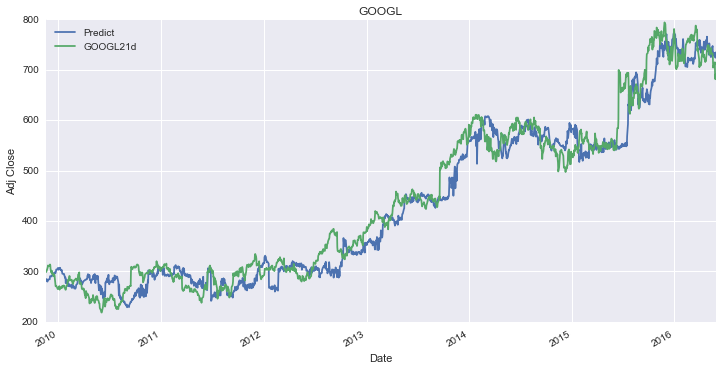

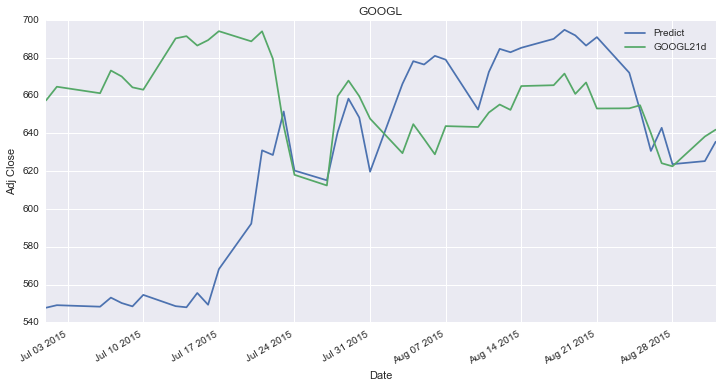

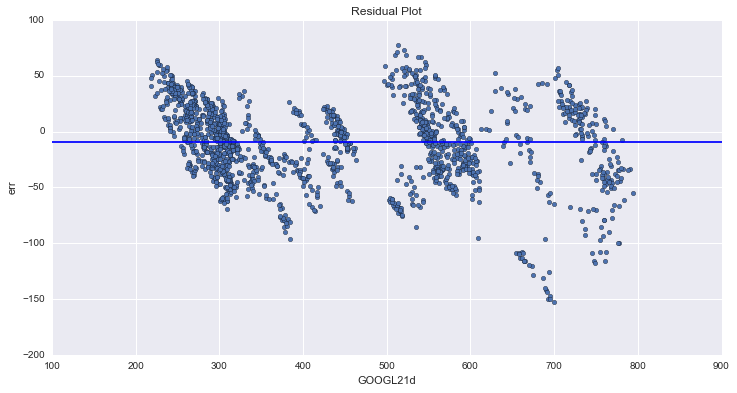

Err mean: -9.38784692259
Err Std: 34.9843557115


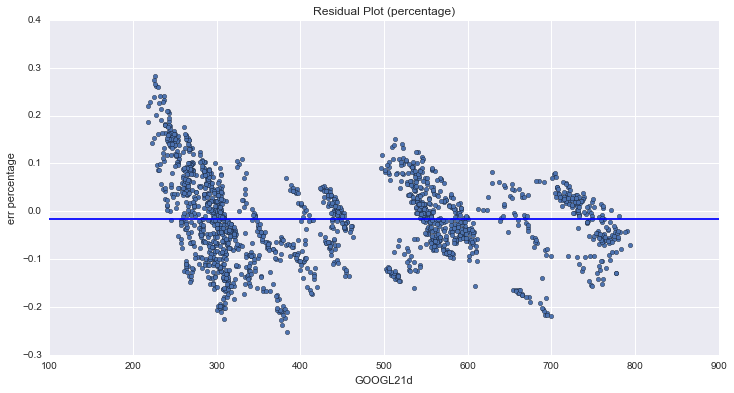

Err percentage mean: -1.59804824224%
Err percentage Std: 8.59215030921%
Err percentage 95% CI: (-0.18782348860661482, 0.15586252376178869)


Smallest R^2:
[0.13688877551218537]


Smallest symbols:
['IGT']
0.675120203862
Outlier R^2:
[0.39956474101193051, 0.65784327958237976, 0.67460473653740594, 0.67311819511113824, 0.64138951369340791, 0.41868806231231992, 0.56097349791783202, 0.43790772235898967, 0.13688877551218537, 0.57287998225953563, 0.57694688595833576, 0.6308120353140062, 0.59491372699437883, 0.63598509115617952, 0.63400354715052409, 0.64080162080996339]


Outlier symbols:
['EXC', 'FLIR', 'SPLS', 'L', 'LXK', 'AES', 'KSS', 'CTXS', 'IGT', 'LUK', 'EXPD', 'BHI', 'CHRW', 'JNPR', 'CAT', 'ZION']
11058.9657941 seconds elapsed for training/predicting/reporting.




In [11]:
# Supervised Learning
from sklearn import grid_search
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Find the n smallest elements in list
def more_min(arr, n_smallest=1):
    result_list = []

    if n_smallest > len(arr):
        raise ValueError("n_smallest greater than the length of the list!")
    else:
        arr_temp = list(arr)

        for i in range(n_smallest):
            result_list.append(np.min(arr_temp))
            arr_temp.remove(np.min(arr_temp))

        return result_list

# Find outliers
def get_outliers(arr):
    q75, q25 = np.percentile(arr, [75 ,25])
    iqr = q75 - q25
    
    thres = q25 - 1.5 * iqr
    print(thres)
    result = [u for u in arr if u < thres]
    
    return result

def make_predictions(data_X, data_y, date_range, estimator, window=121):
    pred_y_list = []
### Commented out code for monitoring feature importance of the RF
#     feature_importance_list = []
    
    for date in date_range:
        test_X = data_X.ix[date]
        (u,) = data_X.index.get_indexer_for([date])
        
        if u - window < 0:
            raise ValueError("Not enough training data!")
            
        train_X = data_X.iloc[(u - window):u - 21]
        train_y = data_y.iloc[(u - window):u - 21]

        estimator.fit(train_X, train_y)
        pred_y = estimator.predict(test_X.reshape(1, -1))
        pred_y_list.append(pred_y)
        
        ## Create feature importance histogram
#         feature_importance_list.append(estimator.feature_importances_)
    
#     vif = [int(np.argmax(x)) for x in feature_importance_list]
#     vif = pd.DataFrame(vif)
#     d = np.diff(np.unique(vif)).min()
#     left_of_first_bin = vif.min() - float(d)/2
#     right_of_last_bin = vif.max() + float(d)/2
#     vif.plot.hist(alpha=0.5, bins=np.arange(left_of_first_bin, right_of_last_bin + d, d))
    return pred_y_list

lr = RandomForestRegressor(criterion='mse', bootstrap=True)
reg = lr

r2_list = []
mse_list = []
min_list = []

def train_and_report():
    start_time = time.time()
    
    for stock_name in stock_dict:
        stock_dict[stock_name]['test_y'] = stock_dict[stock_name]['data_y'][121:]
        stock_dict[stock_name]['pred_y'] = pd.Series(make_predictions(stock_dict[stock_name]['data_X'], stock_dict[stock_name]['data_y'], stock_dict[stock_name]['data_y'].index[121:], reg, 121))
        stock_dict[stock_name]['pred_y'] = pd.DataFrame(stock_dict[stock_name]['pred_y'].tolist(), index=stock_dict[stock_name]['test_y'].index, columns=['Predict'])

    for stock_name in stock_dict:
        stock_dict[stock_name]['R2'] = r2_score(stock_dict[stock_name]['test_y'], stock_dict[stock_name]['pred_y'])
        stock_dict[stock_name]['MSE'] = mean_squared_error(stock_dict[stock_name]['test_y'], stock_dict[stock_name]['pred_y'])

    test_y = stock_dict[symbol]['test_y']
    pred_y = stock_dict[symbol]['pred_y']

    print(symbol)
    print(reg.__class__.__name__)
    print("R^2: {}".format(stock_dict[symbol]['R2']))
    print("MSE: {}".format(stock_dict[symbol]['MSE']))

    for stock_name in stock_dict:
        stock_dict[stock_name]['dfResult'] = stock_dict[stock_name]['pred_y'].join(stock_dict[stock_name]['test_y'], )
        stock_dict[stock_name]['dfResult'].columns = ['Predict', stock_dict[stock_name]['label_name']]

    dfResult2 = stock_dict[symbol]['dfResult']

    # Stock price line chart
    ax = dfResult2.plot(figsize=(12, 6), title=symbol)
    ax.set_xlabel("Date")
    ax.set_ylabel("Adj Close")
    
    ax = dfResult2.ix[datetime(2015, 7, 1):datetime(2015, 9, 1)].plot(figsize=(12, 6), title=symbol)
    ax.set_xlabel("Date")
    ax.set_ylabel("Adj Close")
    
    for stock_name in stock_dict:
        stock_dict[stock_name]['diff'] = (stock_dict[stock_name]['dfResult']['Predict'] - stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']]).to_frame()
        stock_dict[stock_name]['diff'] = stock_dict[stock_name]['diff'].join(stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']])
        stock_dict[stock_name]['diff'].columns = ['err', stock_dict[stock_name]['label_name']]

    diff2 = stock_dict[symbol]['diff']

    diff2.plot.scatter(x=label_name, y='err', title='Residual Plot', figsize=(12, 6))
    plt.axhline(y=diff2['err'].mean())
    plt.show()

    print("Err mean: {}".format(diff2['err'].mean()))
    print("Err Std: {}".format(diff2['err'].std()))

    for stock_name in stock_dict:
        stock_dict[stock_name]['diff_percent'] = ((stock_dict[stock_name]['dfResult']['Predict'] - stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']]) / stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']]).to_frame()
        stock_dict[stock_name]['diff_percent'] = stock_dict[stock_name]['diff_percent'].join(stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']])
        stock_dict[stock_name]['diff_percent'].columns = ['err percentage', stock_dict[stock_name]['label_name']]

    diff3 = stock_dict[symbol]['diff_percent']    

    diff3.plot.scatter(x=label_name, y='err percentage', title='Residual Plot (percentage)', figsize=(12, 6))
    plt.axhline(y=diff3['err percentage'].mean())
    plt.show()

    print("Err percentage mean: {}%".format(diff3['err percentage'].mean() * 100))
    print("Err percentage Std: {}%".format(diff3['err percentage'].std() * 100))
    print("Err percentage 95% CI: {}".format((diff3['err percentage'].mean() - 2 * diff3['err percentage'].std(), diff3['err percentage'].mean() + 2 * diff3['err percentage'].std())))
    print("\n")

    # Get R2 and MSE list of all stocks
    global r2_list
    global mse_list
    global min_list
    
    r2_list = [stock_dict[x]['R2'] for x in stock_dict]
    mse_list = [stock_dict[x]['MSE'] for x in stock_dict]
    
    # Smallest R^2 list
    min_list = more_min(r2_list, 1)
    print("Smallest R^2:")
    print(min_list)
    print("\n")

    # Get smallest R^2 symbols
    min_id_list = [r2_list.index(x) for x in min_list]
    min_symbol_list = [stock_dict.keys()[x] for x in min_id_list]
    print("Smallest symbols:")
    print(min_symbol_list)
    
    # Outlier R^2 list
    outlier_list = get_outliers(r2_list)
    print("Outlier R^2:")
    print(outlier_list)
    print("\n")
    
    # Get outlier R^2 symbols
    outlier_id_list = [r2_list.index(x) for x in outlier_list]
    outlier_symbol_list = [stock_dict.keys()[x] for x in outlier_id_list]
    print("Outlier symbols:")
    print(outlier_symbol_list)
    
    print("{} seconds elapsed for training/predicting/reporting.".format(time.time() - start_time))
    print("\n")

def report_multiple():
    print("R^2 (mean): {}%".format(np.mean(r2_list) * 100))
    print("R^2 (std): {}%".format(np.std(r2_list) * 100))
    print("R^2 (95% CI): {}".format((np.mean(r2_list) - 2 * np.std(r2_list), np.mean(r2_list) + 2 * np.std(r2_list))))

    # R2 Boxplot
    df_r2 = pd.DataFrame(r2_list)
    df_r2['Stock ID'] = df_r2.index
    df_r2.columns = ["R2", "Stock ID"]
    
    display(df_r2.describe())

    ax = sns.boxplot(y='R2', data=df_r2, orient='v')
    ax = sns.stripplot(y="R2", data=df_r2, jitter=0.05)

    #Evaluate the consistency of the residuals
    err_percent_mean_list = [stock_dict[x]['diff_percent']['err percentage'].mean() for x in stock_dict]
    err_percent_std_list = [stock_dict[x]['diff_percent']['err percentage'].std() for x in stock_dict]
    print("Err percentage mean (avg): {}".format(np.mean(err_percent_mean_list)))
    print("Err percentage Std (avg): {}".format(np.mean(err_percent_std_list)))
    print("Err percentage 95% CI (avg): {}".format((np.mean(err_percent_mean_list) - 2 * np.mean(err_percent_std_list), np.mean(err_percent_mean_list) + 2 * np.mean(err_percent_std_list))))
    
    # Err Mean Boxplot
    df_err = pd.DataFrame(err_percent_mean_list)
    df_err['Stock ID'] = df_err.index
    df_err.columns = ["Err Percentage Mean", "Stock ID"]

    display(df_err.describe())
    
    plt.figure()
    ax_err = sns.boxplot(y="Err Percentage Mean", data=df_err, orient='v', color='.45')
    ax_err = sns.stripplot(y="Err Percentage Mean", data=df_err, jitter=0.05)

    # Err Std Boxplot
    df_err_std = pd.DataFrame(err_percent_std_list)
    df_err_std['Stock ID'] = df_err_std.index
    df_err_std.columns = ["Err Percentage Std", "Stock ID"]

    display(df_err_std.describe())
    
    plt.figure()
    ax_err_std = sns.boxplot(y="Err Percentage Std", data=df_err_std, orient='v', color='.55')
    ax_err_std = sns.stripplot(y="Err Percentage Std", data=df_err_std, jitter=0.05)
    
train_and_report()

Now let's see how our method generally performs across the S&P 500 (2009) stocks.

R^2 (mean): 87.072504351%
R^2 (std): 12.3698273398%
R^2 (95% CI): (0.62332849671419122, 1.118121590304866)


,R2,Stock ID
count,198.000000,198.000000
mean,0.870725,98.500000
std,0.124012,57.301832
min,0.136889,0.000000
25%,0.841325,49.250000
50%,0.909911,98.500000
75%,0.952128,147.750000
max,0.986228,197.000000


Err percentage mean (avg): -0.00482227051813
Err percentage Std (avg): 0.0982076174813
Err percentage 95% CI (avg): (-0.20123750548077535, 0.19159296444451857)


,Err Percentage Mean,Stock ID
count,198.000000,198.000000
mean,-0.004822,98.500000
std,0.027700,57.301832
min,-0.039826,0.000000
25%,-0.016869,49.250000
50%,-0.009856,98.500000
75%,-0.000976,147.750000
max,0.206246,197.000000


,Err Percentage Std,Stock ID
count,198.000000,198.000000
mean,0.098208,98.500000
std,0.062424,57.301832
min,0.037598,0.000000
25%,0.067652,49.250000
50%,0.088548,98.500000
75%,0.108515,147.750000
max,0.674761,197.000000


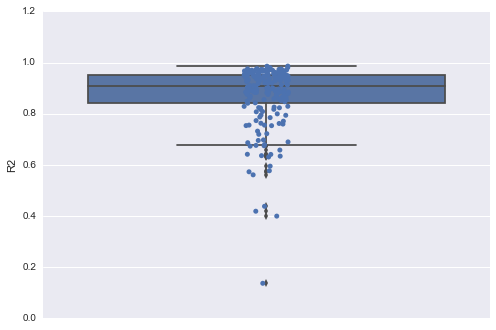

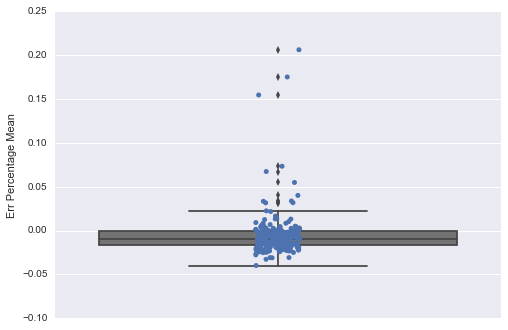

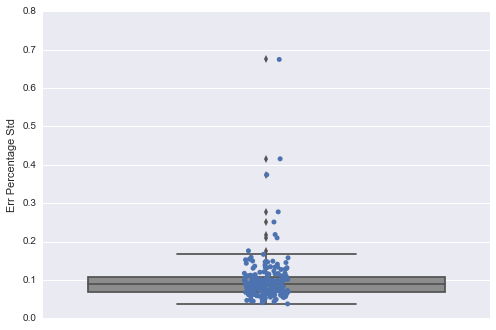

In [12]:
report_multiple()

In [13]:
# # dfResult2.ix[datetime(2015, 7, 1):datetime(2015, 9, 1)].plot(figsize=(12, 6))
# ax = dfResult2.plot(figsize=(12, 6), title='GOOGL')
# ax.set_xlabel("GOOGL Adj Close")
# ax.set_ylabel("Date")

### Refinement
#### Grid Search and Cross Validation
As discussed earlier, there are couple of parameters we can tune to improve the random forest algorithm. In this section we will try to improve our model by focusing on the following aspects:

1. Try different number of trees
2. Try different number of max features to consider when building trees

According to *How Many Trees in a Random Forest?* (https://www.researchgate.net/publication/230766603_How_Many_Trees_in_a_Random_Forest), the goldilocks lies somewhere bewteen 64 to 128 trees. Any futher number of trees only adds computational cost. We shall try some numbers in that zone.

As to the max features, we shall try to grid search through the following methods:

1. Square root of N (N being number of features)
2. Log2 of N
3. N

#### Validity test
Due to the lack of resource, we won't be able to optimize for all the stocks. As a proof of concept, we will use one to make our point.

0.0420320034027 seconds elapsed for loading data.


GOOGL
GridSearchCV
R^2: 0.953586215733
MSE: 1227.51835711


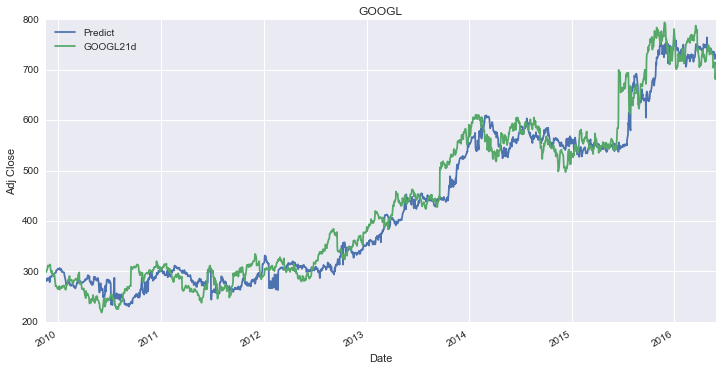

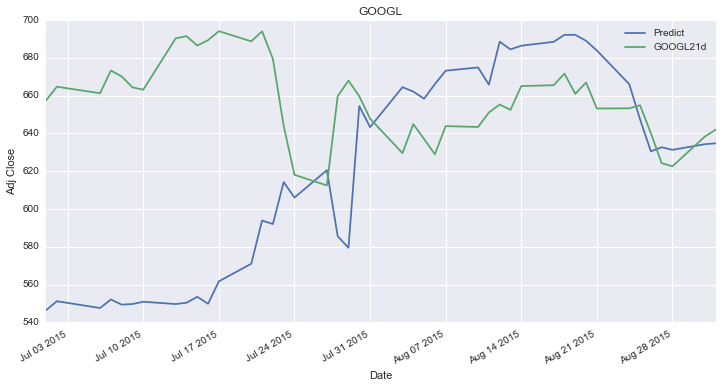

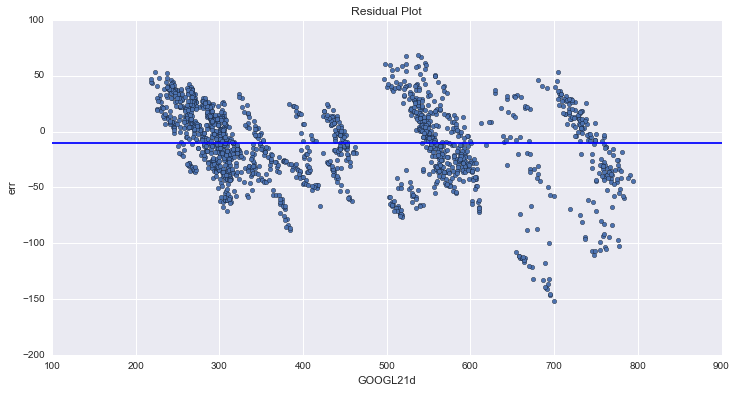

Err mean: -10.2693494896
Err Std: 33.5073511851


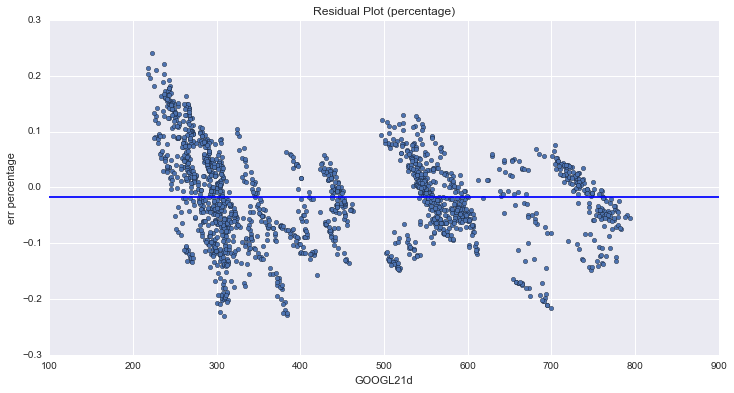

Err percentage mean: -1.75791323757%
Err percentage Std: 8.0093514286%
Err percentage 95% CI: (-0.1777661609477032, 0.14260789619623909)


Smallest R^2:
[0.95358621573255653]


Smallest symbols:
['GOOGL']
0.953586215733
Outlier R^2:
[]


Outlier symbols:
[]
58171.5510099 seconds elapsed for training/predicting/reporting.




In [14]:
# Load data
symbol = 'GOOGL'
stock_dict = load_data('sp500_2009.csv', 'stock_data/SPY.csv', start_date, end_date, number_of_stocks=0, include_stocks=[symbol])
df_main = stock_dict[symbol]['original_data']

# Forward/Backward fill missing values
stock_dict = fill_missing_data(stock_dict)
df_main = stock_dict[symbol]['original_data']

# Ready Label data
window = 21
stock_dict = ready_label_data(stock_dict, window)

for stock_name in stock_dict:
    stock_dict[stock_name]['data_y'].dropna(inplace=True)

label_name = stock_dict[symbol]['label_name']
data_y = stock_dict[symbol]['data_y']

# Feature log transform
for stock_name in stock_dict:
    stock_dict[stock_name]['log_data'] = np.sign(stock_dict[stock_name]['original_data']) * np.log(abs(stock_dict[stock_name]['original_data']) + 1)

log_data = stock_dict[symbol]['log_data']

# Feature engineering
for stock_name in stock_dict:
    stock_dict[stock_name]['log_data'] = feature_engineer(stock_name, stock_dict[stock_name]['log_data'])
    stock_dict[stock_name]['data_X'] = stock_dict[stock_name]['log_data']
    stock_dict[stock_name]['data_y'] = stock_dict[stock_name]['data_y'].ix[stock_dict[stock_name]['data_X'].index]
    stock_dict[stock_name]['data_y'].dropna(inplace=True)
    stock_dict[stock_name]['data_X'] = stock_dict[stock_name]['data_X'].ix[stock_dict[stock_name]['data_y'].index]

log_data = stock_dict[symbol]['log_data']
data_X = stock_dict[symbol]['data_X']
data_y = stock_dict[symbol]['data_y']

lr = RandomForestRegressor(criterion='mse', bootstrap=True)
parameters = {'n_estimators': [10, 64, 97, 128], 'max_features': ['sqrt', 'auto']}
reg = grid_search.GridSearchCV(lr, parameters, cv=9, scoring='mean_squared_error')

train_and_report()

We can validate the refinement with $r^2$.

The result is showing $r^2 = 0.953586215733 > 0.950418665722$

## Results
### Model Evaluation and Validation
The model we use in this project is ensemble-based. To be more precise, it's an ensemble of ensemble algorithm (random forest) because for each stock and each price instance, we build a model. And then we apply this method across 198 (to ensure 5% margin of error at 95% of confidence level) stocks randomly picked from S&P 500 (2009) to make sure the method itself is robust and can be generally applied.

The result is showing that the mean of error percentage means across the 198 stocks are -0.004822, and medians are -0.009856. This shows that our method can generally make predictions not favoring any sides (postive or negative). As for the the standard deviation, the mean of error percentage standarad deviations are 0.098208 and medians being 0.088548.

### Justification
We set our benchmark to tolerate 10% of error on prediction while we have achieved a 9.82% on mean and 8.85% on median, meeting our inital goal.

On the refinement side, although we were not able to do refinement on all the sample data, the grid search on trying out different combinations of parameters is showing improvement on GOOGL. We belive this can be applied to all the SPY stocks.

## Conclusion
### Free-Form Visualization
One thing to note from the residual plot is that
![title](residual.png)

The error has an obvious tendency of going from the top left to the bottom right. This of course is no coincidence. The stock price of GOOGL has trend of going up and to the left and none of the mean averages in the past are able to capture that trend. In order to solve this problem, a more predictive indicator has to be identified and included in our feature set. 

### Reflection
When I first started working on the project, I was not very familiar with this topic. Not with stock markets, nor with finance or economics. My original thought was that I should try without knowing anything about the data and the domain knowledge, and then tried to pick up bit by bit while I muddled through it. And this was exactly what I did.

There were quite a few places that I found puzzled and difficult.

First is the benchmark. I had no idea what a reasonable benchmark should be. How precise the prediction need to be? How far into the future do I want to predict? And can I predict that with the data?

The second is working with time series data. It's my first time working with time series data. The "physics" behind the scene is dynamic and time-dependent. How do I convert this data into something I can work with traditional machine learning methods, without losing information and constrains?

Third comes to model building. Should we build one model to predict for all the stocks? Or should we build one for each? If I build each of them independently, how do I incorporate sector information?

There are a lot more than what I've listed here, but these are the ones that came to mind first and were definitely among the hardest. However, though the word difficulty is used here, never for a second did I think any of them was difficult. Now that I think back, I think it's because I didn't know what would a reasonable goal be so there was not much pressure. The only thing that kept driving me forward was how to improve it, how to make it better. All of these questions are not so easy to answer, but my ignorance definitely lent me a hand this time.

The intereting part of this project is that on my way of building it, I started to feel more and more like a trader as more and more mystery that was completely unknown to me started to unravel. Now that approaching the end of the project, I know that I know so much about trading, finance, even business that I can debate with friends that have been working in the finance sector for more than ten years. How cool is that?

I'm confident this forecaster is useful in real trading if combined with a good portfolio optimizer (which is something I'm going to build next). And with a proper online learning setting and good UI, I can see the potential of this making into a promising product.

### Improvement
With the performance meeting the benchmark, the result is surely satisfactory. However, there definitely is a lot of room for improvement. We shall list a few here:

1. **Grid search through more combinations of parameter:** Due to lack of resource, there are quite few promising combinations we are missing out
2. **Use K-fold cross-validation: **K-fold CV is expensive but is really good to have
2. **More feature engineering:** Try more features (technial analysis) and use PCA
3. **Training window size:** It's not very clear how much we should date back for training data
4. **Introduce more ideas from behavioral finance and pattern recognition:** Incorporate behavioral finance knowledge into feature engineering and use unsupervised learning to discover hidden patterns